# Example 3: Inversion of RT-models

## 1. Narrative (Inversion of RT-models, soil moisture retrieval from radar backscatter)

This notebook demonstrates a workflow for retrieving soil moisture (sm) from radar backscatter (**synthetic data set**).

The main process is:
1. **Parametrization**: Defining the physical properties of the soil and vegetation.
2. **Forward Modeling** (creating a synthetic dataset): Simulating what a microwave satellite (e.g., Sentinel-1) would "see" (backscatter) given the parametrization of the soil and vegetation.
3. **Inversion**: Using an optimization solver to find the soil moisture value that best matches the 
   observed backscatter.
4. **Visualization**: Visualize the difference between the synthetic created truth of soil moisture (sm_truth) and the modeled soil moisture


## 2. Requirements

- Installation of SenSE

## 3. Retrieval of soil moisture with RT-model combination **Oh92+SSRT**

### 3.1 Parametrization

First of all, we need to import several packages

In [1]:
import numpy as np
#from sense.surface import Dubois95
from sense.util import f2lam
from sense.model import RTModel
from sense.soil import Soil
from sense.canopy import OneLayer
import matplotlib.pyplot as plt
import random
from sense.surface import Oh92, Oh04
from scipy.optimize import minimize

Next step is to define which RT models should be used (example combination of surface: Oh92 and canopy: SSRT)

In [ ]:
# Choose models (surface: Oh92; canopy: SSRT (turbid_isotropic))
#------------------------------------------------------------------
canopy = 'turbid_isotropic' # other options are 'turbid_rayleigh' or 'water_cloud' 
surface = 'Oh92' # other options are 'Oh04", 'Dubois95', 'I2EM', 'WaterCloud'
models = {'surface' : surface, 'canopy' : canopy}
pol='vv' # use of Vertical-Vertical polarization due to its sensitivity to soil moisture

After the definition of the model the model model parameters need to be defined. Furthermore, for the parameter soil moisture (sm) a synthetic time series is created.

In [3]:
# model parameter Oh92 (surface part)
#----------------------
freq = 5.405           # Frequency in GHz (C-band, typical for Sentinel-1)
s = 0.013              # Surface roughness (m)
clay = 0.0738          # Clay fraction (0-1)
sand = 0.2408          # Sand fraction (0-1)
bulk = 1.45            # Soil bulk density (g/cm3)
theta = np.deg2rad(35) # Incidence angle in radians

# Generating a synthetic time series of soil moisture
sm_truth = np.random.uniform(low=0.05, high=0.35, size=(50,))

# model parameter SSRT (canopy part)
#---------------------
d = 0.55               # Canopy height (m)
tau = 0.45             # Optical depth (unitless) - characterizes attenuation
ke = tau/d             # Extinction coefficient
omega = 0.175          # Single scattering albedo
ks = omega * ke        # Scattering coefficient

### 3.2 Forward modeling

Forward simulation. Using the previously defined model parameter to create a "synthetic truth" dataset of sigma nought radar backscatter values (simuulated Sentinel-1 backscatter values for vv polarization).

In [4]:
# run model to produce backscatter
#----------------------------------
S = Soil(f=freq, s=s, mv=sm_truth, sand=sand, clay=clay, bulk=bulk)
C = OneLayer(ke_h=ke, ke_v=ke, d=d, ks_v=ks, ks_h=ks, canopy=models['canopy'])
RT = RTModel(theta=theta, models=models, surface=S, canopy=C, freq=freq)
RT.sigma0()
back_vv = RT.stot['vv']
back_hv = RT.stot['hv']

Let's put some uncertainty (15%) on the synthetic (truth) backscatter time series

In [5]:
# put uncertainty on backscatter
unc = np.random.uniform(low=-np.mean(back_vv)*0.15, high=np.mean(back_vv)*0.15, size=(len(back_vv),))
back_vv = back_vv - unc

### 3.3 Inversion

Define some helper function so that we can run the RT model in an inversion process. The aim is to provide backscatter to the RT model thus we can retrieve soil moisture values 

In [6]:
# Helper Functions for Soil Moisture Retrieval (Inversion)
# ---------------------------------------------------------

def run_model(dic, models):
    """
    Executes the Forward Radiative Transfer Model.
    This function takes physical parameters (soil moisture, roughness, vegetation)
    and simulates what the radar backscatter (sigma0) should look like.
    """
    
    # 1. Define Soil Properties: 
    # mv = volumetric soil moisture, s = surface roughness, f = frequency
    soil = Soil(mv=dic['mv'], s=dic['s'], clay=dic['clay'], 
                sand=dic['sand'], f=dic['f'], bulk=dic['bulk'])

    # 2. Define Canopy (Vegetation) Properties:
    # d = height, ke = extinction coefficient, omega = single scattering albedo
    # We calculate scattering coefficients (ks) based on the extinction and albedo.
    can = OneLayer(canopy=dic['canopy'], ke_h=dic['ke'], ke_v=dic['ke'], d=dic['d'], 
                   ks_h = dic['omega']*dic['ke'],
                   ks_v = dic['omega']*dic['ke'])

    # 3. Combine into the Radiative Transfer Model (RTModel):
    # theta = incidence angle of the satellite sensor
    S = RTModel(surface=soil, canopy=can, models=models, theta=dic['theta'], freq=dic['f'])
    
    # Run the simulation
    S.sigma0()
    
    # Return the total backscatter for VV and VH polarizations
    # Note: [::-1] is used here to ensure the dictionary key matches the internal naming
    return S.__dict__['stot']['vv'[::-1]], S.__dict__['stot']['vh'[::-1]]


def solve_fun(VALS, var_opt, dic, models):
    """
    Bridge function that updates the parameter dictionary with the 
    current 'guess' from the optimizer and runs the model.
    """
    for i in range(len(var_opt)):
        dic[var_opt[i]] = VALS[i]

    vv, vh = run_model(dic, models)
    return vv, vh


def fun_opt(VALS, var_opt, dic, models, pol):
    """
    The Objective (Cost) Function.
    This calculates the 'error' between the satellite observation and our model.
    The optimizer tries to minimize this value to find the true soil moisture.
    """
    
    # We use Least Squares (np.square) to penalize larger differences between 
    # the observed data (dic['vv']) and the simulated data (solve_fun(...)).
    
    if pol == 'vv':
        # Minimize error for VV polarization only
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])))
    
    elif pol == 'vh':
        # Minimize error for VH polarization only (often used for vegetation)
        return(np.nansum(np.square(solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])))
    
    elif pol == 'vv_vh':
        # Dual-polarization retrieval: seeks a balance that fits both VV and VH signals
        return(np.nansum(np.square((solve_fun(VALS, var_opt, dic, models)[0]-dic['vv'])/2 + 
                                   (solve_fun(VALS, var_opt, dic, models)[1]-dic['vh'])/2)))

Now we can run the inversion process to estimate soil moisture based on a synthetic radar backscatter time series

In [7]:
# Execution of the Soil Moisture Retrieval (Inversion Loop)
# ---------------------------------------------------------

# Initial Dictionary: Stores all constant physical and sensor parameters.
# These values (roughness, clay content, frequency, etc.) are held constant 
# while we solve for the unknown variable (soil moisture).
dic = {
    "mv": 0.2,      # Initial placeholder for soil moisture
    "s": s,         # Soil roughness (m)
    "clay": clay,   # Clay fraction
    "sand": sand,   # Sand fraction
    "f": freq,      # Radar frequency (GHz)
    "bulk": bulk,   # Soil bulk density
    "canopy": canopy, 
    "d": d,         # Vegetation height (m)
    "ke": ke,       # Extinction coefficient
    "vv": back_vv,  # VV Polarization backscatter (Target)
    "vh": back_hv,  # VH Polarization backscatter
    "theta": theta, # Incidence angle
    "omega": omega  # Single scattering albedo
}

# Optimization Configuration
var_opt = ['mv']      # The variable we want to retrieve (Soil Moisture)
guess = [0.2]         # The starting point for the solver (20% moisture)
bounds = [(0.05, 0.35)] # Physical limits: prevents the solver from picking impossible values

# 'L-BFGS-B' is a common algorithm for "constrained" optimization.
# It is efficient for finding the minimum of a function within specific bounds.
method = 'L-BFGS-B'

# List to store the results for each time-step or pixel
sm_retrieved = []

# Loop through each radar observation (Backscatter time-series or array)
for i, ii in enumerate(back_vv):
    
    # Update the dictionary with the specific observation for this iteration.
    # We feed the solver the exact backscatter (VV and VH) measured by the satellite.
    dic = {
        "mv": 0.2, "s": s, "clay": clay, "sand": sand, "f": freq, "bulk": bulk, 
        "canopy": canopy, "d": d, "ke": ke, "vv": back_vv[i], "vh": back_hv[i], 
        "theta": theta, "omega": omega
    }
    
    # The Minimize function:
    # It repeatedly calls 'fun_opt', adjusting the 'mv' value until the 
    # simulated backscatter matches the observed backscatter (back_vv[i]).
    res = minimize(fun_opt, guess, args=(var_opt, dic, models, pol), 
                   bounds=bounds, method=method)

    # Optional: Execute the function one last time with the optimized result 
    # to verify the final cost/error.
    fun_opt(res.x, var_opt, dic, models, 'vv')
    
    # Append the successful retrieval (res.x[0]) to our results list
    sm_retrieved.append(res.x[0])

# Result: 'sm_retrieved' now contains the estimated soil moisture values
# corresponding to your radar backscatter inputs.


### 3.4 Visualization

Let's see how the original soil moisture compares to the model retrieved soil moisture (remember we put some uncertainty on the synthetic radar backscatter time series)

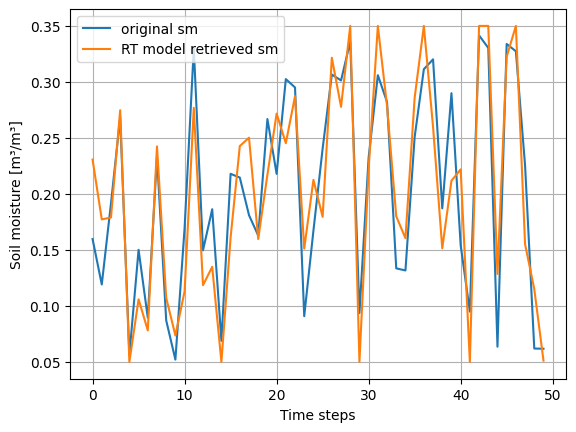

In [9]:
# Visualization
# --------------
plt.plot(sm_truth, label='original sm')
plt.plot(sm_retrieved, label='RT model retrieved sm')
plt.xlabel('Time steps')
plt.ylabel('Soil moisture [m³/m³]')
plt.grid()
plt.legend()

In [10]:
# Difference between retrieved and truth (synthetic) soil moisture
# -----------------------------------------------------------------
diff = sm_truth - sm_retrieved
diff_average = np.sum(abs(diff))/len(diff)
print(diff)
print(diff_average)

[-0.07096531 -0.05807146  0.01251829 -0.00632529  0.00620911  0.04418123
  0.01134357 -0.00903754 -0.02017916 -0.02151024  0.05653444  0.05320612
  0.03115364  0.0514544   0.01884815  0.05680743 -0.02811593 -0.0691892
  0.00311033  0.04973507 -0.05383806  0.05722382  0.00780491 -0.06037814
 -0.04537121  0.06090895 -0.01498087  0.02355465 -0.0140295   0.04369223
  0.0104189  -0.04397722  0.00366088 -0.04648176 -0.02879221 -0.03507189
 -0.03865148  0.06035384  0.03567255  0.07813208 -0.06770152  0.04486928
 -0.00846511 -0.01962522 -0.06494518  0.01139348 -0.02261724  0.07030648
 -0.05304622  0.01062841]
0.03630178393595633
